In [1]:
import time,os

import tensorflow as tf
import numpy as np

import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import custom_vgg19
import Lib
import InputPipeline

In [2]:
BATCH_SIZE=10
NEW_H=256
NEW_W=256
input_shape = [BATCH_SIZE, 256, 256, 3]
img_ph = tf.placeholder(dtype=tf.float32, shape=input_shape)
img_pred = Lib.buildTransformNet(img_ph, input_shape, useNonHackScaling=True)

conv layer, output size: [10, 256, 256, 32]
conv layer, output size: [10, 128, 128, 64]
conv layer, output size: [10, 64, 64, 128]
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
deconv layer, output size: [10, 128, 128, 64]
deconv layer, output size: [10, 256, 256, 32]
conv layer, output size: [10, 256, 256, 3]


In [4]:
import os
test_batch_f = filter(lambda s:s.startswith('COCO'), os.listdir('contents/smalltestset/'))[:BATCH_SIZE]
assert len(test_batch_f) == BATCH_SIZE, ('not enough files', len(test_batch_f))
test_batch_np = np.zeros(input_shape)
for i in xrange(BATCH_SIZE):
    test_batch_np[i] = load_image_as_batch_with_optional_resize('contents/smalltestset/'+test_batch_f[i], newH=NEW_H, newW=NEW_W)
    
sess=tf.Session()
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()
saver.restore(sess, "chkpts/udnie.ckpt")

(0.5, 0.99988681)
(0.5, 0.99999058)
(0.5, 0.9999541)
(0.5, 0.99999452)
(0.5, 0.99988776)
(0.5, 0.99999869)
(0.5, 0.99956584)
(0.5, 0.99989223)
(0.5, 0.99993551)


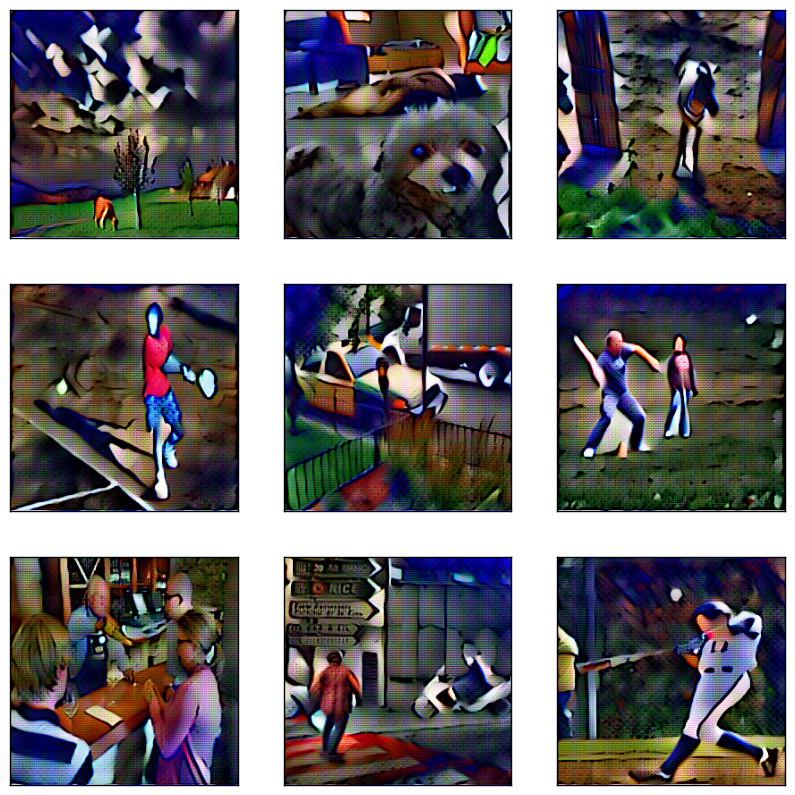

In [8]:
img_pred_np = sess.run(img_pred, feed_dict={img_ph: test_batch_np})

f,axarr=plt.subplots(3,3, figsize=(10,10))
for i in xrange(3):  
    for j in xrange(3):
        img = np.clip(img_pred_np[i*3+j],0,1)
        axarr[i][j].imshow(img*2-1)
        axarr[i][j].xaxis.set_visible(False)
        axarr[i][j].yaxis.set_visible(False)
        print(np.min(img_pred_np[i*3+j]), np.max(img_pred_np[i*3+j]))
plt.show()

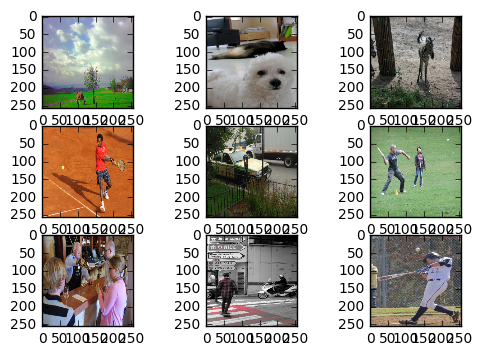

In [6]:
f,axarr=plt.subplots(3,3)
for i in xrange(3): 
    for j in xrange(3): 
        axarr[i][j].imshow(test_batch_np[i*3+j])
plt.show()

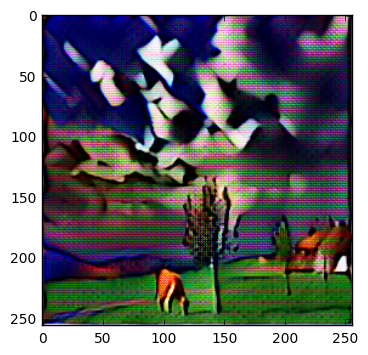

In [7]:
img = img_pred_np[0]*2-1
plt.imshow(np.clip(img,0,1))
plt.show()